# **LOADING LIBRARIES**

In [1]:
import os
import time
import shutil
import random

In [2]:
import cv2
import pandas as pd
import seaborn as sn
from google.colab.patches import cv2_imshow
from keras.preprocessing import image

In [3]:
import tensorflow as tf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [6]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

# **DECLARING VARIABLES VALUE**

In [7]:
EPOCHS = 20
BATCH_SIZE = 64
WIDTH = 224
HEIGHT = 224
LEARNING_RATE = 0.001
CLASSES = 30
SEED = random.randint(1, 1000)
top_dropout_rate = 0.2

# **SETTING PATH**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
final_model = '/content/drive/MyDrive/EfficientNet_B0_Transfer.h5'
hist_path = '/content/drive/MyDrive/EfficientNetB0T_Hist.log'
fine_tune_model = '/content/drive/MyDrive/EfficientNet_B0_Fine_tune.h5'
fine_tune_hist = '/content/drive/MyDrive/EfficientNetB0_FT_Hist.log'

In [10]:
train_dir = "/content/drive/MyDrive/data_train"
test_dir = "/content/drive/MyDrive/data_test"


# **PREPARING DATASET**

In [11]:
traingen = ImageDataGenerator(
    shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 90,
    brightness_range = [0.7, 1.1],
    horizontal_flip = True,
    preprocessing_function = preprocess_input,
    validation_split = 0.15
)

In [12]:
train_generator = traingen.flow_from_directory(
    train_dir,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = SEED,
    subset = 'training'
)

Found 15785 images belonging to 30 classes.


In [13]:
val_generator = traingen.flow_from_directory(
    train_dir,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = SEED,
    subset = 'validation'
)

Found 2767 images belonging to 30 classes.


In [11]:
testgen = ImageDataGenerator()

test_generator = testgen.flow_from_directory(
    test_dir,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = SEED
)
class_names = test_generator.class_indices.keys()

Found 4626 images belonging to 30 classes.


# **TRAINING MODEL**

## **I. Initialize Pretrained Model:**

In [ ]:
base_model = EfficientNetB0(include_top = False, weights = 'imagenet', input_shape = (WIDTH, HEIGHT, 3))
for layer in base_model.layers: 
  layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = Dense(CLASSES, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = outputs)
model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
tf.keras.utils.plot_model(model, dpi=60)

## **II. Freezing all layers and training top layers:**

In [17]:
checkpoint = ModelCheckpoint(
    fine_tune_model,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 5,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_lr = 0.0000001,
    min_delta =.0001,
    patience = 3,
    factor = np.sqrt(0.1),
    cooldown = 0,
    verbose = 1
)

In [ ]:
params = model.fit(
    train_generator, 
    validation_data = val_generator, 
    epochs = EPOCHS,
    callbacks = [checkpoint, early_stopping, reduce_lr, CSVLogger(hist_path)],
    verbose = 1
)

Epoch 1/20
247/247 [==============================] - 503s 2s/step - loss: 1.5512 - accuracy: 0.5634 - val_loss: 0.9493 - val_accuracy: 0.7409

Epoch 00001: val_accuracy improved from -inf to 0.74087, saving model to /content/drive/MyDrive/EfficientNet_B0_Transfer.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
247/247 [==============================] - 494s 2s/step - loss: 0.9176 - accuracy: 0.7301 - val_loss: 0.7447 - val_accuracy: 0.7850

Epoch 00002: val_accuracy improved from 0.74087 to 0.78497, saving model to /content/drive/MyDrive/EfficientNet_B0_Transfer.h5
Epoch 3/20
247/247 [==============================] - 496s 2s/step - loss: 0.7984 - accuracy: 0.7614 - val_loss: 0.6924 - val_accuracy: 0.8023

Epoch 00003: val_accuracy improved from 0.78497 to 0.80231, saving model to /content/drive/MyDrive/EfficientNet_B0_Transfer.h5
Epoch 4/20
247/247 [==============================] - 493s 2s/step - loss: 0.7263 - accuracy: 0.7837 - val_loss: 0.6582 - val_accuracy: 0.8066

Epoch 00004: val_accuracy improved from 0.80231 to 0.80665, saving model to /content/drive/MyDrive/EfficientNet_B0_Transfer.h5
Epoch 5/20
247/247 [==============================] - 492s 2s/step - loss: 0.6770 - accuracy: 0.7915 - val_loss: 0.6450 - val_accuracy: 0.8106

Epoch 00005: val_accuracy improved from 0.8

In [23]:
def plot_hist(path):
  history = pd.read_csv(path)

  acc = history['accuracy']
  val_acc = history['val_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(20, 10))

  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()), 1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('epoch')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Categorical Crossentropy')
  plt.ylim([min(plt.ylim()), max(plt.ylim())])
  plt.title('Training and Validation Loss')

  plt.xlabel('epoch')
  plt.savefig('evaluation.jpg')
  plt.show()

In [24]:
model = load_model(final_model)

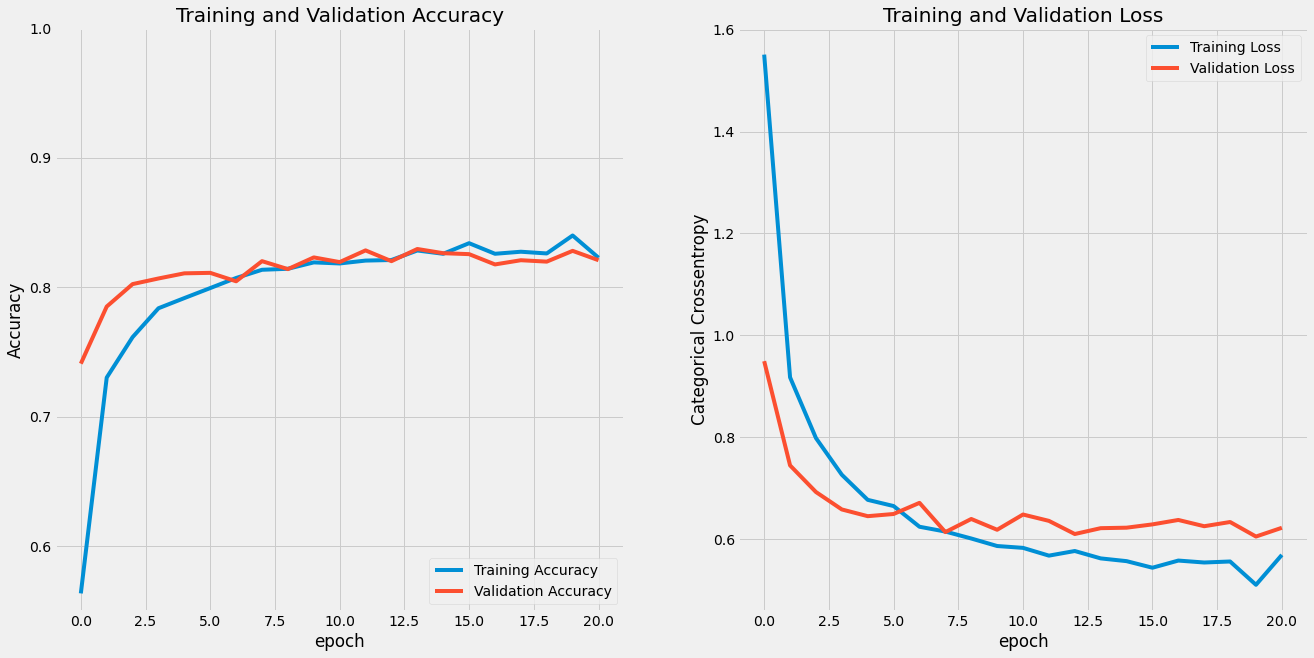

In [28]:
plot_hist(hist_path)

## **III. Unfreezing some layers and fitting the model:**

In [20]:
set_trainable = False
for layer in model.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
params = model.fit(
    train_generator, 
    validation_data = val_generator, 
    epochs = 10,
    callbacks = [checkpoint, early_stopping, reduce_lr, CSVLogger(fine_tune_hist, append=True)],
    verbose = 1
)

Epoch 1/10
247/247 [==============================] - 497s 2s/step - loss: 0.4910 - accuracy: 0.8467 - val_loss: 0.6173 - val_accuracy: 0.8276

Epoch 00001: val_accuracy did not improve from 0.83448
Epoch 2/10
247/247 [==============================] - 502s 2s/step - loss: 0.4817 - accuracy: 0.8488 - val_loss: 0.6175 - val_accuracy: 0.8352

Epoch 00002: val_accuracy improved from 0.83448 to 0.83520, saving model to /content/drive/MyDrive/EfficientNet_B0_Fine_tune.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10
247/247 [==============================] - 498s 2s/step - loss: 0.4784 - accuracy: 0.8491 - val_loss: 0.6086 - val_accuracy: 0.8330

Epoch 00003: val_accuracy did not improve from 0.83520
Epoch 4/10
247/247 [==============================] - 499s 2s/step - loss: 0.4721 - accuracy: 0.8530 - val_loss: 0.6107 - val_accuracy: 0.8428

Epoch 00004: val_accuracy improved from 0.83520 to 0.84279, saving model to /content/drive/MyDrive/EfficientNet_B0_Fine_tune.h5
Epoch 5/10
247/247 [==============================] - 497s 2s/step - loss: 0.4731 - accuracy: 0.8471 - val_loss: 0.6094 - val_accuracy: 0.8215

Epoch 00005: val_accuracy did not improve from 0.84279
Epoch 6/10
247/247 [==============================] - 503s 2s/step - loss: 0.4799 - accuracy: 0.8476 - val_loss: 0.5991 - val_accuracy: 0.8359

Epoch 00006: val_accuracy did not improve from 0.84279
Epoch 7/10
247/247 [==============================] - 497s 2s/step - loss: 0.4734 - accuracy: 0.8497 - val_loss: 0.6001 - val_accur

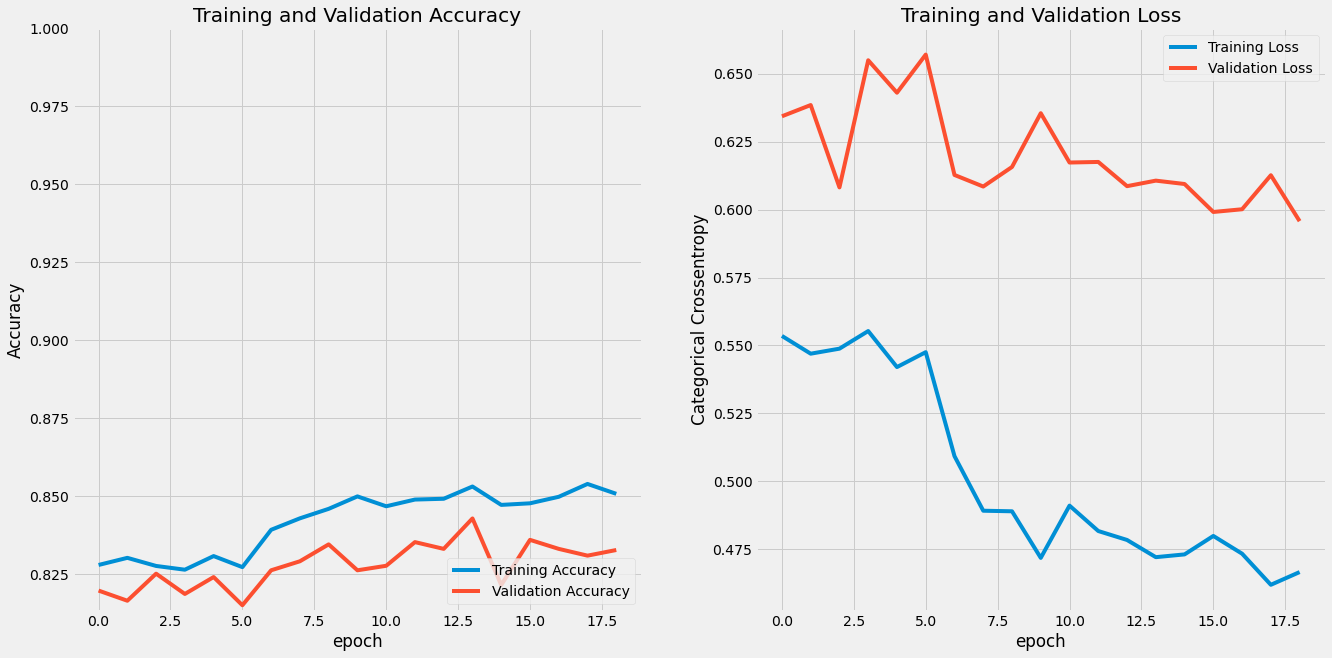

In [27]:
plot_hist(fine_tune_hist)

# **EVELUATION**

## **I. Accuracy:**

In [15]:
model = load_model(fine_tune_model)

In [17]:
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

73/73 [==============================] - 2294s 32s/step - loss: 0.5591 - accuracy: 0.8476


In [18]:
print('Train accuracy:', train_accuracy)
print('Validation accuracy:', val_accuracy)
print('Test accuracy:', test_accuracy)

Train accuracy: 0.9130820631980896
Validation accuracy: 0.8366461992263794
Test accuracy: 0.847600519657135


## **II. Confusion matrix:**

In [30]:
Predict = model.predict(test_generator)
predicts = np.argmax(Predict, axis = 1)

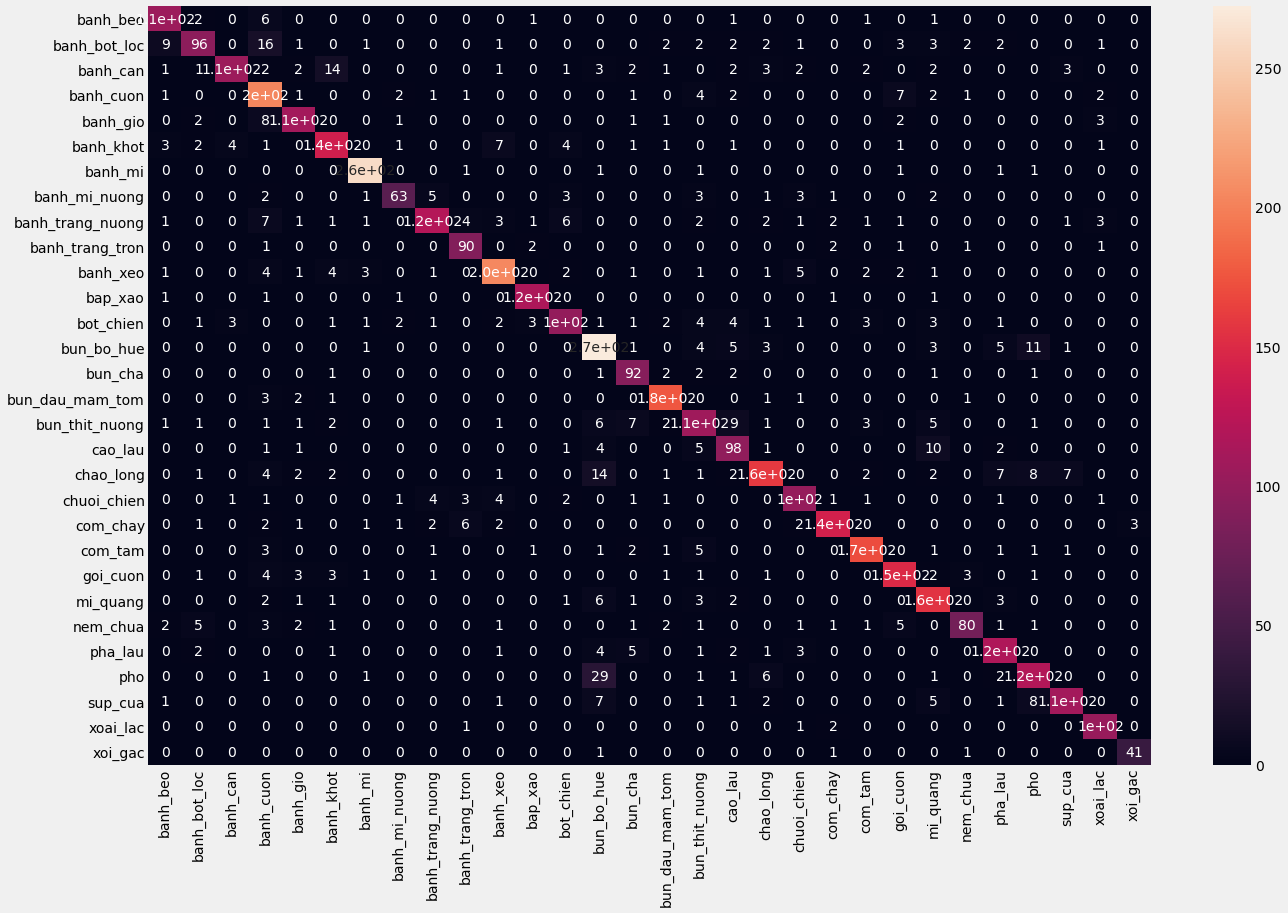

In [31]:
matrix = np.array(tf.math.confusion_matrix(test_generator.classes, predicts))

df_cm = pd.DataFrame(
    matrix, 
    index = test_generator.class_indices.keys() ,
    columns = test_generator.class_indices.keys())
plt.figure(figsize = (20, 13))
sn.heatmap(df_cm, annot=True)

## **III. Classification report:**

In [32]:
print(classification_report(test_generator.classes, predicts, target_names = class_names))

                  precision    recall  f1-score   support

        banh_beo       0.83      0.90      0.87       118
    banh_bot_loc       0.83      0.67      0.74       144
        banh_can       0.93      0.72      0.81       148
       banh_cuon       0.74      0.89      0.81       228
        banh_gio       0.85      0.86      0.86       128
       banh_khot       0.81      0.84      0.83       167
         banh_mi       0.96      0.98      0.97       267
   banh_mi_nuong       0.88      0.75      0.81        84
banh_trang_nuong       0.88      0.76      0.82       159
 banh_trang_tron       0.85      0.92      0.88        98
        banh_xeo       0.89      0.88      0.88       234
         bap_xao       0.94      0.96      0.95       121
       bot_chien       0.83      0.74      0.78       135
      bun_bo_hue       0.78      0.89      0.83       306
         bun_cha       0.79      0.90      0.84       102
 bun_dau_mam_tom       0.91      0.95      0.93       185
  bun_thit_nu

# **PREDICTION**

In [12]:
model = load_model(fine_tune_model)

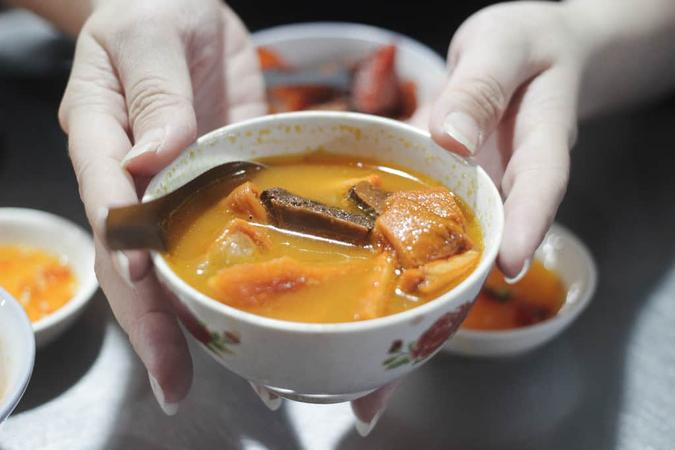

0.99994886 pha_lau


In [21]:
img_path = '/content/drive/MyDrive/anhrtest/phalau.jpg'
img = image.load_img(img_path, target_size = (224, 224))
Image = cv2.imread(img_path)
cv2_imshow(Image)
x=image.img_to_array(img)
x=np.expand_dims(x, axis = 0)
predict = np.argmax(model.predict(x))
classes = list(class_names)
print(max(model.predict(x)[0]), classes[predict])

In [23]:
def prediction(path, model):
  img=image.load_img(path, target_size=(224, 224))
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  predict = model.predict(x)
  class_name = list(class_names)
  return class_name[np.argmax(predict)], str(int(max(predict[0])*10000)/100)

In [24]:
def test_predict(cols, rows, test_path):
  fig = plt.figure(figsize = (30,25))
  i = 0
  for name_true in class_names:
    path = test_path + '/' + name_true +'/' + name_true +'_'+ str(random.randint(1,44)) + '.jpg'
    image = plt.imread(path)
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.axis('off')
    name, ability = prediction(path, model)
    plt.title("True: "+ name_true +"\nPredict: " +name + " " + ability +"%")
    i = i+1

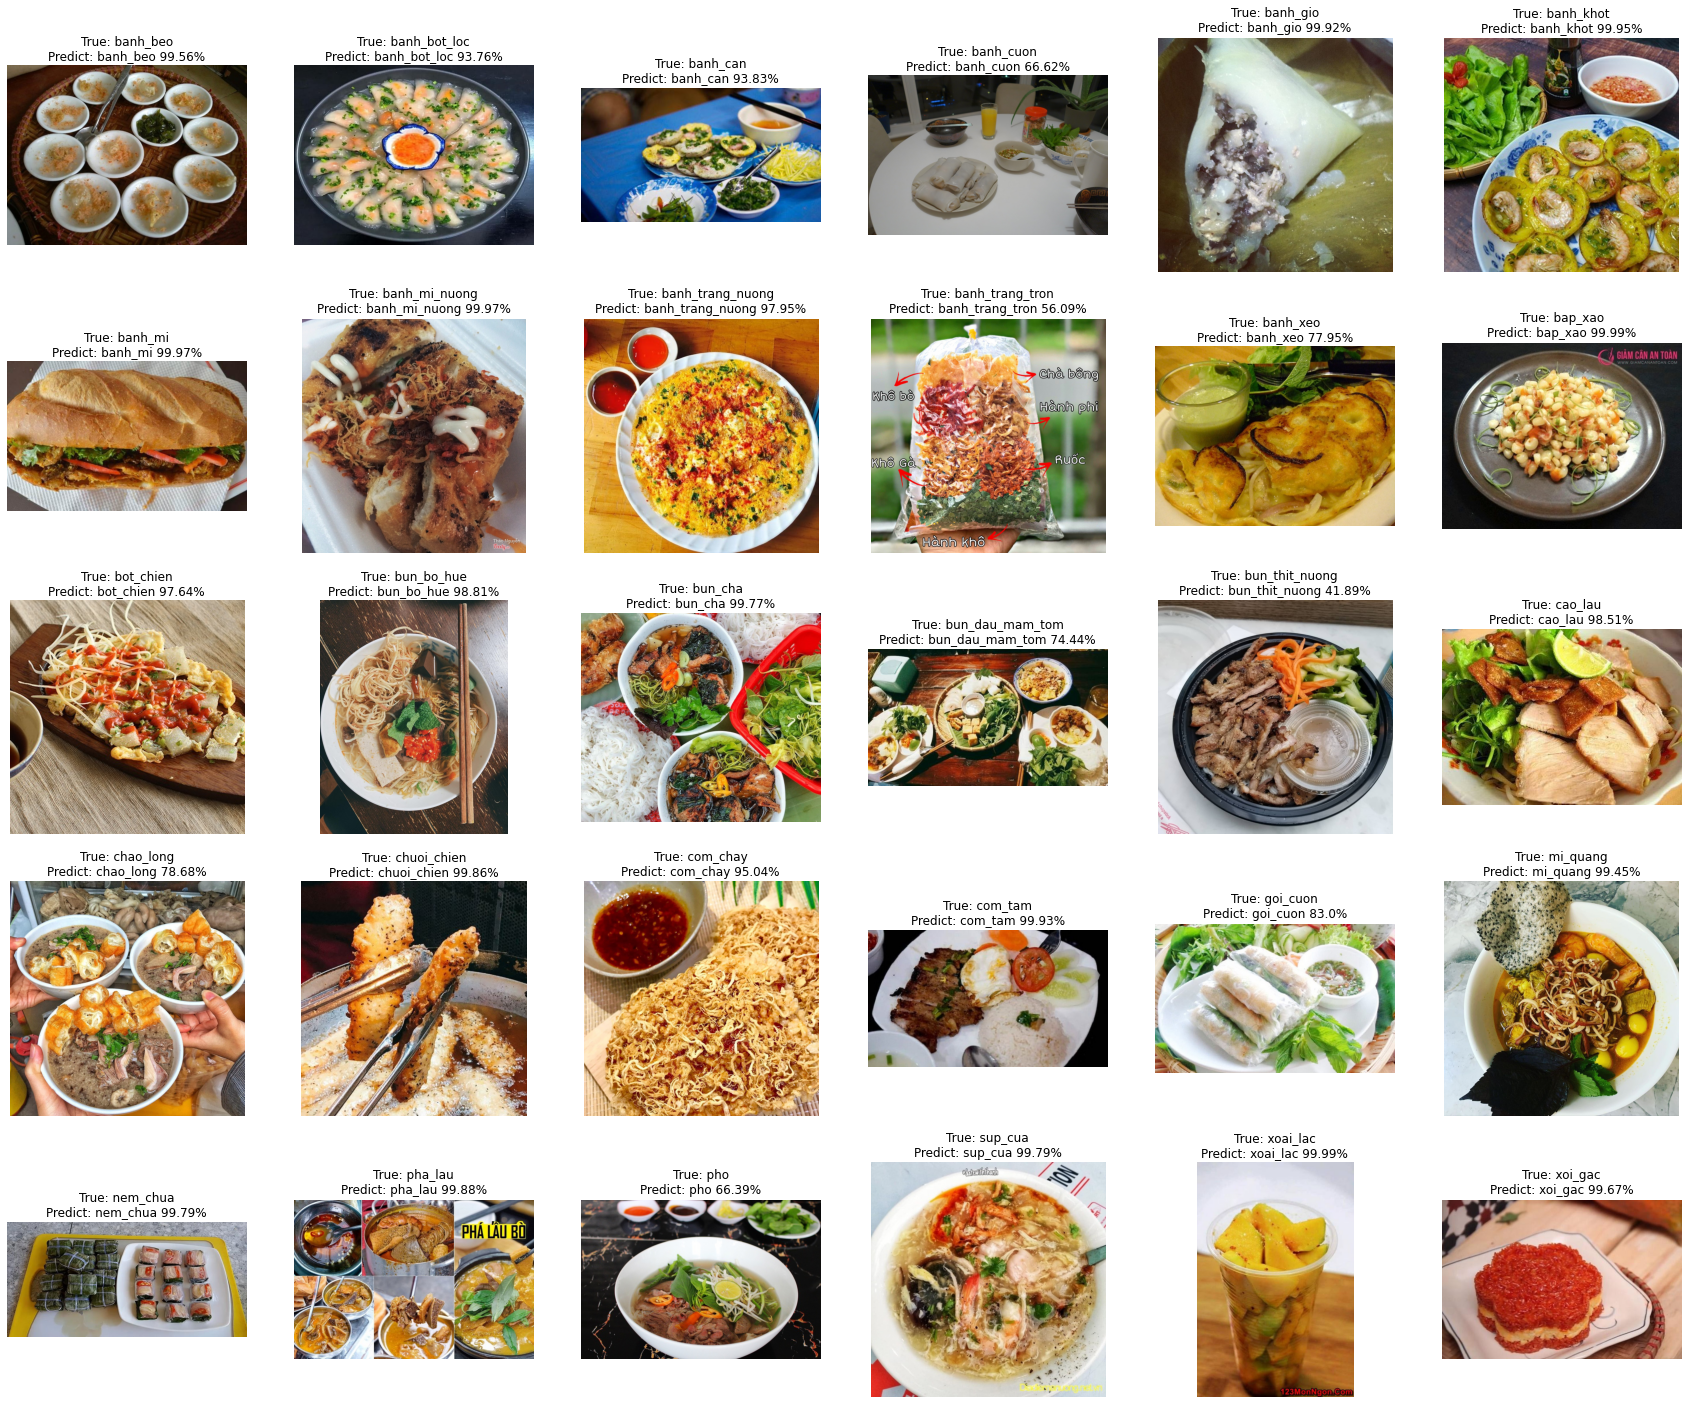

In [25]:
test_predict(6, 5, test_dir)